# Training On Colab

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
import torchvision
import time
import copy
from torch.utils.data import random_split
%matplotlib inline

In [110]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
# ! gdown 1--8vsO1vdweI57LQhetIs19bdqow_0ww
! gdown 18Y783nfsvYMBXAAb4Vin4-fXrbW0IlWJ

Downloading...
From: https://drive.google.com/uc?id=18Y783nfsvYMBXAAb4Vin4-fXrbW0IlWJ
To: /content/aziz3.zip
100% 1.41G/1.41G [00:17<00:00, 78.4MB/s]


In [ ]:
# ! unzip final_f_dataset.zip 
! unzip aziz3.zip 

In [128]:
! rm -rf ./data/.ipy*

In [129]:
DATASET_ROOT = './data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.functional.to_pil_image(x).convert('RGBA') if x.shape[0] == 4 else transforms.functional.to_pil_image(x)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = datasets.ImageFolder(DATASET_ROOT, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, test_size + len(dataset) - train_size - test_size * 2])

# Create data loaders for the training and testing sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# get the labels
labels = []
for _, dirs, _ in os.walk(DATASET_ROOT):
  labels.extend(dirs)
labels = [label for label in labels if label != '']
labels

['Fashion and Style',
 'Food and Dining',
 'Pets',
 'Technology and Gadgets',
 'Sports and Fitness',
 'Entertainment',
 'News',
 'Family and relationships',
 'Travel and Adventure',
 'business_and_industry',
 'Art and culture']

In [130]:
import torch.nn as nn
import torch.hub

class Model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Model, self).__init__()
        self.model = torch.hub.load(
            'pytorch/vision:v0.9.0', 'vgg11', weights=pretrained)
        self.model.fc = torch.nn.Linear(
            self.model.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x
from tqdm import tqdm

class CnnTrainer():
    def __init__(self, model, trainloader, valloader, learning_rate=0.01, momentum=0.9, step_size=7, gamma=0.1):
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.trainloader = trainloader
        self.valloader = valloader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(
            self.model.parameters(), lr=learning_rate, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=step_size, gamma=gamma)

    def train(self, num_epochs):
        best_acc = 0.0
        loss = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        
        for epoch in range(num_epochs):
            self.model.train()
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print("-" * 10)
            progress_bar = tqdm(self.trainloader, ncols=100)  # Add progress bar
            running_loss = 0.0
            running_corrects = 0
            for i, inputs, labels in enumerate(progress_bar):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()
                with torch.enable_grad():
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update the progress bar
                progress_bar.set_description(
                    f"Train Loss: {running_loss / (i+1):.4f} Train Acc: {running_corrects.double() / (i+1):.4f}"
                )

            self.scheduler.step()
            epoch_loss = running_loss / len(self.trainloader.dataset)
            epoch_acc = running_corrects.double() / len(self.trainloader.dataset)
            print(f"\nTrain Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}")
            self.model.eval()
            val_loss, val_acc = self._evaluate()
            if val_acc > best_acc:
                best_acc = val_acc
                loss = val_loss
                best_model_wts = copy.deepcopy(self.model.state_dict())
                print(f"Best val Acc: {best_acc:4f} Best val loss : {val_loss:4f}\n")
        return best_model_wts, loss, best_acc

    def _evaluate(self):
        with torch.no_grad():
            val_running_loss = 0.0
            val_running_corrects = 0
            for val_inputs, val_labels in self.valloader:
                val_inputs = val_inputs.to(self.device)
                val_labels = val_labels.to(self.device)

                val_outputs = self.model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss = self.criterion(val_outputs, val_labels)

                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data)

            val_loss = val_running_loss / len(self.valloader.dataset)
            val_acc = val_running_corrects.double() / len(self.valloader.dataset)
        return val_loss, val_acc

In [132]:
num_classes = len(set(dataset.targets))
classifier = Model(num_classes)
trainer = CnnTrainer(classifier, trainloader, testloader, 0.001)
classifier.model.requires_grad = True

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [141]:
model, _, _ = trainer.train(7)

Epoch 1/1
----------


Train Loss: 0.1310 Train Acc: 0.9492: 100%|█| 1444/1444 [03:04<00:00,  7.81it/s]


Train Loss: 0.1310 Train Acc: 0.9492


Best val Acc: 0.880808 Best val loss : 0.373387



In [142]:
torch.save(model, './cnn_instagram.pt')

In [143]:
! cp cnn_instagram.pt /content/drive/MyDrive/PFA/

# Inference

In [1]:
! gdown 1IrHolYUB69JN35IGiGf3zeY0fNz6hNjG

/bin/bash: /anaconda/envs/azureml_py38/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Downloading...
From (uriginal): https://drive.google.com/uc?id=1IrHolYUB69JN35IGiGf3zeY0fNz6hNjG
From (redirected): https://drive.google.com/uc?id=1IrHolYUB69JN35IGiGf3zeY0fNz6hNjG&confirm=t&uuid=f4fe6af0-e0c4-441c-986e-64395fdda41d
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/pfa-gl4/code/Users/mohamedazizkhayati/instagram_users_interests/cnn_instagram.pt
100%|████████████████████████████████████████| 532M/532M [00:11<00:00, 44.5MB/s]


In [ ]:
# Load the model 
model = torch.load('../artifacts/cnn_instagram.pt')

In [ ]:
def eval_model(model_state_dict, testloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = len(dataset.classes)
    
    model = Model(num_classes)
    model.load_state_dict(model_state_dict)
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(testloader.dataset)
    accuracy = running_corrects.double() / len(testloader.dataset)

    print('---------------------------------------------')
    print(f"Loss on test: {loss:.4f} Acc: {accuracy:.4f}")
    print('---------------------------------------------')


In [153]:
eval_model(model, valloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


---------------------------------------------
Loss on test: 0.3561 Acc: 0.8816
---------------------------------------------


In [158]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_predictions(model_state_dict, testloader, labels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(dataset.classes)
    model = Model(num_classes)
    model.load_state_dict(model_state_dict)
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()

    # Select a few random images from the test dataset
    num_images = 8
    indices = np.random.choice(len(testloader.dataset), num_images, replace=False)
    images, targets = [], []
    for idx in indices:
        image, target = testloader.dataset[idx]
        images.append(image)
        targets.append(target)  # Get the index of the target label


    # Prepare the images for prediction
    images = torch.stack(images).to(device)

    # Perform predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels = predicted_labels.cpu().numpy()

    # Plot the images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(24, 3))
    for i, (image, target, predicted_label) in enumerate(zip(images, targets, predicted_labels)):
        image = image.cpu().numpy().transpose((1, 2, 0))
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Undo normalization

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {dataset.classes[predicted_label]}\nTrue: {dataset.classes[target]}")

    plt.tight_layout()
    plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


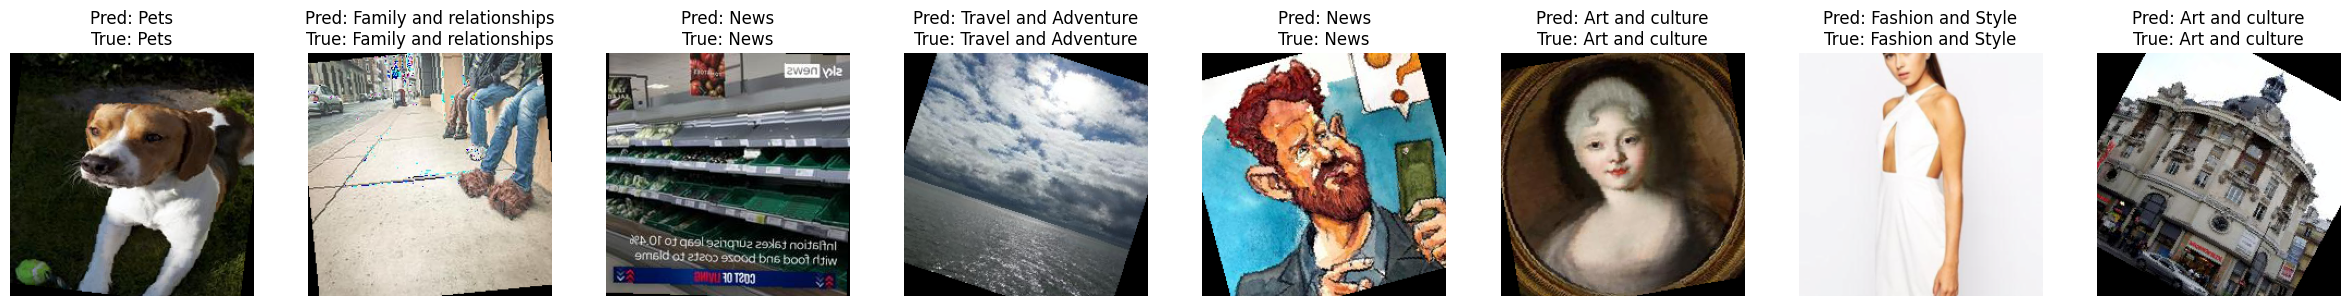

In [159]:
# Call the function with your trained model, testloader, and labels
plot_images_with_predictions(model, valloader, labels)